In [ ]:
# цитата на хабре: https://tldrify.com/130t
# dataset http://study.mokoron.com/
# Рубцова Ю. Автоматическое построение и анализ корпуса коротких текстов (постов микроблогов)
# для задачи разработки и тренировки тонового классификатора 
# //Инженерия знаний и технологии семантического веба. – 2012. – Т. 1. – С. 109-116.

# База данных состоит из 12 столбцов:

# – id: уникальный номер сообщения в системе twitter;
# – tdate: дата публикации сообщения (твита);
# – tmane: имя пользователя, опубликовавшего сообщение;
# – ttext:  текст сообщения (твита);
# – ttype: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);
# – trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
# – tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
# – tstcount: число всех сообщений пользователя в сети twitter;
# – tfol: количество фоловеров пользователя (тех людей, которые читают пользователя);
# – tfrien: количество друзей пользователя (те люди, которых читает пользователь);
# – listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

In [ ]:
# загружаем файлы
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving negative.csv to negative.csv
Saving positive.csv to positive.csv
User uploaded file "negative.csv" with length 24450101 bytes
User uploaded file "positive.csv" with length 26233379 bytes


In [ ]:
!pip install pymystem3==0.1.10

  Found existing installation: pymystem3 0.2.0
    Uninstalling pymystem3-0.2.0:
      Successfully uninstalled pymystem3-0.2.0


In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from pymystem3 import Mystem
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# читаем сsv в  dataframe
pos=pd.read_csv('positive.csv', sep=';',header=None)
neg=pd.read_csv('negative.csv', sep=';',header=None)

In [3]:
pos.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [4]:
neg.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [5]:
pos_comm=pos.copy(deep=True).iloc[:,3:5].rename(columns={3: 'text', 4: 'class'})
neg_comm=neg.copy(deep=True).iloc[:,3:5].rename(columns={3: 'text', 4: 'class'})
neg_comm.loc[neg_comm['class'] == -1, 'class'] = 0
display(pos_comm.head())
display(neg_comm.head())

,text,class
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1


,text,class
0,на работе был полный пиддес :| и так каждое за...,0
1,"Коллеги сидят рубятся в Urban terror, а я из-з...",0
2,@elina_4post как говорят обещаного три года жд...,0
3,"Желаю хорошего полёта и удачной посадки,я буду...",0
4,"Обновил за каким-то лешим surf, теперь не рабо...",0


In [6]:
pos_comm.describe()

,class
count,114911.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [7]:
neg_comm.describe()

,class
count,111923.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [8]:
comment = pd.concat([pos_comm.iloc[:len(neg_comm),:], neg_comm],ignore_index=True)

In [9]:
comment['class'].value_counts()

1    111923
0    111923
Name: class, dtype: int64

In [10]:
comment

,text,class
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1
...,...,...
223841,Но не каждый хочет что то исправлять:( http://...,0
223842,скучаю так :-( только @taaannyaaa вправляет мо...,0
223843,"Вот и в школу, в говно это идти уже надо(",0
223844,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0


In [11]:
# препроцессинг текста
# https://www.kaggle.com/alxmamaev/how-to-easy-preprocess-russian-text
# одно "но", не убираем стоп-слова, т.к. для анализа тональности они могут иметь эмоциональную окраску. Например: "не понравился" и "понравился". 
# Для уменьшения энтропии и сохранения точности также можно выбирать стоп-слова, но в этом примере делать этого не будем.
# также данный препроцессинг хорош тем, что он использует лемматизацию, а не стемминг. Суффиксы и словоформы важны, что видно в классическом примере "любимый" и "любимчик".
mystem = Mystem() 
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

In [12]:
# проверяем
display(comment['text'][0])
display(preprocess_text(comment['text'][0]))
print('---------------------')
display(comment['text'][1])
display(preprocess_text(comment['text'][1]))

'@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)'

'first timee хоть я и школоть но поверять у мы то же самый d общество профилирующий предмет тип'

---------------------


'Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D'

'да все-таки он немного похожий на он но мой мальчик весь равный хороший d'

In [13]:
#прогоняем все твиты
comment['text_preprocessing']=comment['text'].apply(preprocess_text)

In [14]:
comment

,text,class,text_preprocessing
0,"@first_timee хоть я и школота, но поверь, у на...",1,first timee хоть я и школоть но поверять у мы ...
1,"Да, все-таки он немного похож на него. Но мой ...",1,да все-таки он немного похожий на он но мой ма...
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,rt katiacheh ну ты идиотка я испугаться за ты !!!
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,"rt digger2912 : "" кто то в угол сидеть и погиб..."
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1,irina dyshkant вот что значить страшилка d но ...
...,...,...,...
223841,Но не каждый хочет что то исправлять:( http://...,0,но не каждый хотеть что то исправлять :( http...
223842,скучаю так :-( только @taaannyaaa вправляет мо...,0,скучать так :-( только taaannyaaa вправлять ...
223843,"Вот и в школу, в говно это идти уже надо(",0,вот и в школа в гавно это идти уже надо
223844,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0,rt them __: lisaberoud тауриэль не грустить ...


In [42]:
# векторизуем
# не убираем стоп-слова, не применяем tf-idf векторайзер, потому что частота использования слова не влияет на эмоциональную окраску текста
# 
vectorizer=CountVectorizer(ngram_range=(1, 3))
X = normalize(vectorizer.fit_transform(comment['text_preprocessing']))
y = np.asarray(comment['class']).astype('float32').reshape((-1,1))
# разобьем на обучающую и тестовую выборку
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #размер тестовой выборки выбран таким для того, чтобы сравнить с результатом на хабре

In [16]:
# метрики - https://coderoad.ru/43547402/%D0%9A%D0%B0%D0%BA-%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B8%D1%82%D1%8C-%D0%BC%D0%B0%D0%BA%D1%80%D0%BE%D1%81-F1-%D0%B2-Keras
# чтобы сравнить с результатом на хабре - также добавил метрики из Keras 1, котрые отсутствуют в Keras 2
def recall(y_true, y_pred): # полнота (доля найденных классфикатором документов принадлежащих классу относительно всех документов этого класса)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred): # точность ( доля документов действительно принадлежащих данному классу относительно всех документов которые система отнесла к этому классу)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred): # f1-мера (объединяет полноту и точность)
    def recall(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall

    def precision(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [17]:
# строим модель
# Керас: https://ru-keras.com/guide-sequential/
# Как считать слои: https://www.machinelearningmastery.ru/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/
# Функции активации: https://neurohive.io/ru/osnovy-data-science/activation-functions/ 
# оптимизаторы: https://habr.com/ru/company/skillfactory/blog/525214/
#               https://ru-keras.com/optimizer/
#               https://habr.com/ru/post/318970/
# будем реализовывать многослойный перцептрон для бинарной классификации (MLP)


def model_SA(train_data):
    model = Sequential() #линейный стек слоев 
    model.add(Dense(units=200,  input_shape=(train_data.shape[1],), activation='relu')) # первый "обычный" плотно связанный слой 
                                                                                 # (в плотно связанных слоях каждый узел в одном слое связан с каждым узлом в следующем слое)
                                                                                 # input_shape - размер входных данных (применяется только для первого слоя)
                                                                                 # activation - функция активации. relu: A(x) = max(0,x)
                                                                                 # такая функция является хорошим аппроксиматором, так как любая функция может быть аппроксимирована комбинацией ReLu
                                                                                 # https://tldrify.com/130x
    model.add(Dropout(rate=0.5))                                                 # Dropout защищает от переобучения, rate- доля блоков для исключения                       
    model.add(Dense(units=40, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, activation='sigmoid'))                              # используем сигмоиду, т.к.  значение функции имеет тенденцию прижиматься к одному из краев кривой.
                                                                                 # Такое поведение позволяет находить четкие границы при предсказании и хорошо показывает себя 
                                                                                 # в задачах классификации
    model.compile(optimizer=Adam(0.001),                                         # компиляция модели. Выбран оптимизатор adam  
                  loss='binary_crossentropy',                                    # функция ошибки, которую модель будет минимизировать, выбрана logloss, т.к.
                                                                                 # для задачи бинарной классификации, в которой алгоритм должен выдать вероятность принадлежности классу 1,
                                                                                 # она логична ровно настолько, насколько логична MSE в задаче линейной регрессии
                  metrics=[precision, recall, f1])                               # метрика для оценки
    return model


model=model_SA(x_train)


# наименьшая ошибка получилась на 29 эпохе, приводить весь лог здесь не будем. сперва эпох было 100
history_training=model.fit(x_train,y_train,batch_size=100000, epochs=29, shuffle=True, validation_data=(x_test, y_test), verbose=1)

Epoch 1/29
2/2 [==============================] - 12s 5s/step - loss: 0.6930 - precision: 0.5712 - recall: 0.3983 - f1: 0.4404 - val_loss: 0.6913 - val_precision: 0.7790 - val_recall: 0.3622 - val_f1: 0.4945
Epoch 2/29
2/2 [==============================] - 9s 4s/step - loss: 0.6905 - precision: 0.7649 - recall: 0.4320 - f1: 0.5499 - val_loss: 0.6870 - val_precision: 0.7492 - val_recall: 0.5742 - val_f1: 0.6501
Epoch 3/29
2/2 [==============================] - 9s 4s/step - loss: 0.6852 - precision: 0.7632 - recall: 0.6116 - f1: 0.6790 - val_loss: 0.6818 - val_precision: 0.7530 - val_recall: 0.6142 - val_f1: 0.6766
Epoch 4/29
2/2 [==============================] - 9s 4s/step - loss: 0.6782 - precision: 0.7799 - recall: 0.6627 - f1: 0.7165 - val_loss: 0.6754 - val_precision: 0.7571 - val_recall: 0.6313 - val_f1: 0.6885
Epoch 5/29
2/2 [==============================] - 9s 4s/step - loss: 0.6692 - precision: 0.7971 - recall: 0.6965 - f1: 0.7434 - val_loss: 0.6680 - val_precision: 0.7567 - 

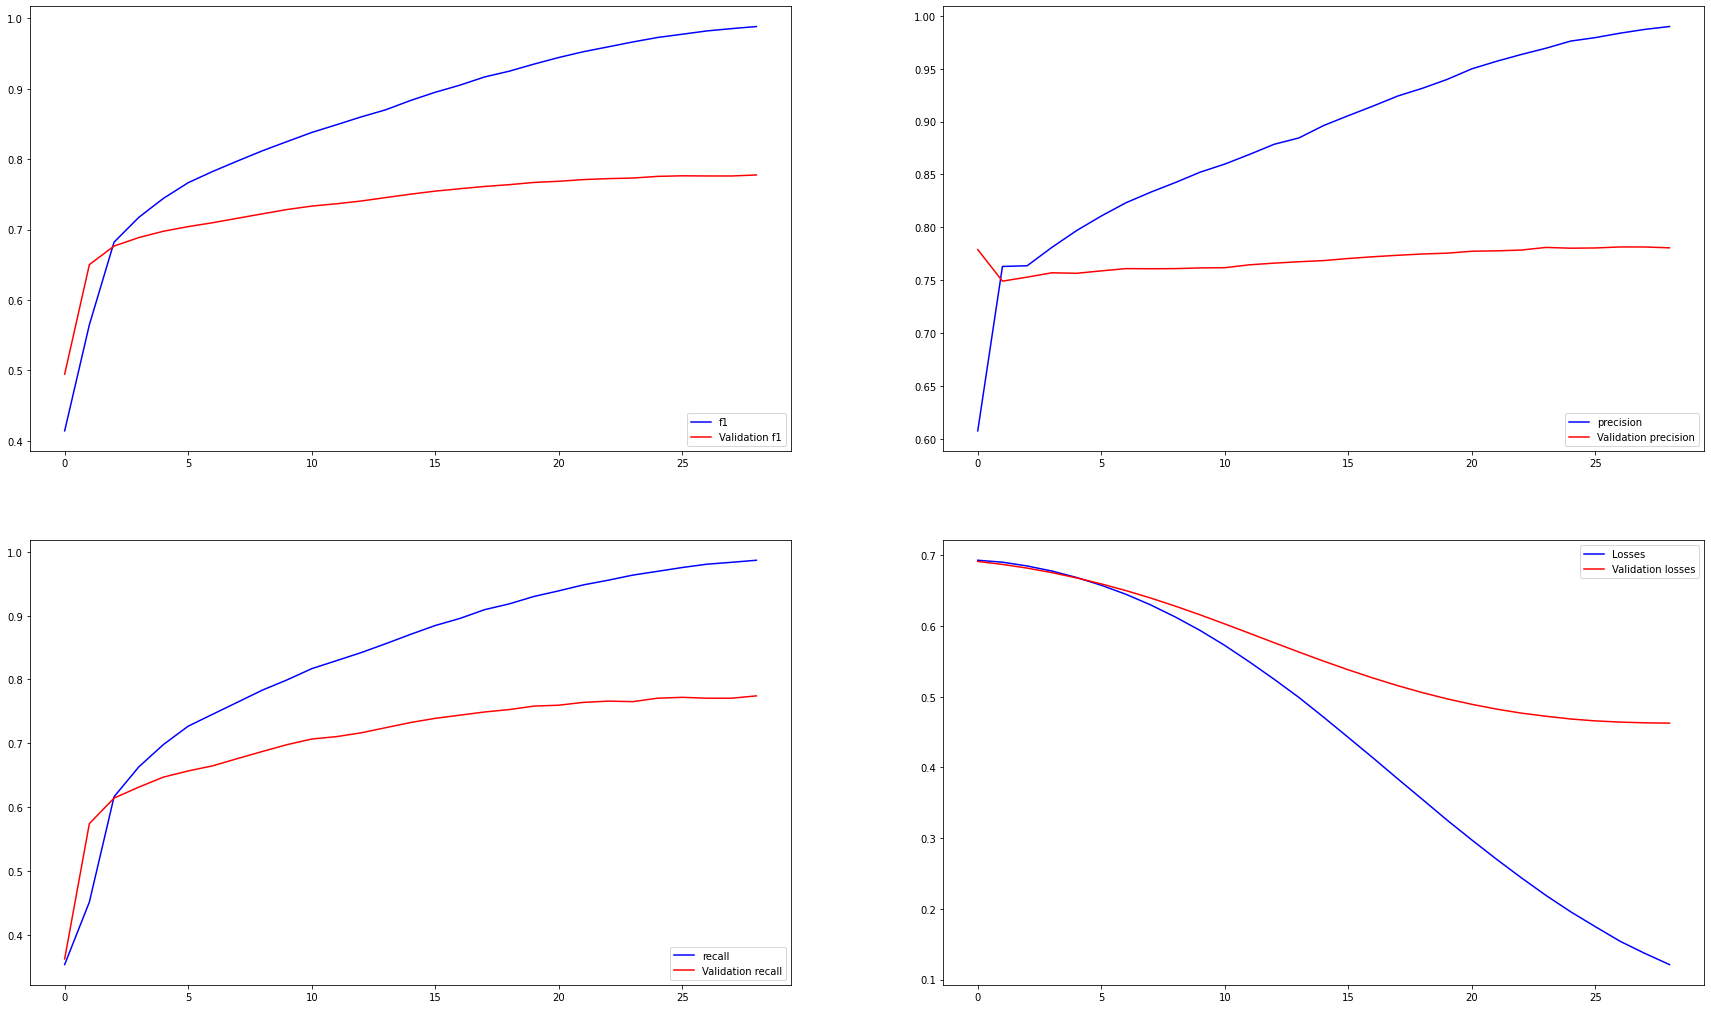

In [19]:
# строим графики
fig = plt.figure(figsize=(30, 18))

sp1= fig.add_subplot(221)
sp2= fig.add_subplot(222)
sp3= fig.add_subplot(223)
sp4 = fig.add_subplot(224)

x = range(29)

sp1.plot(x, history_training.history['f1'], 'b-', label='f1')
sp1.plot(x, history_training.history['val_f1'], 'r-', label='Validation f1')
sp1.legend(loc='lower right')

sp2.plot(x, history_training.history['precision'], 'b-', label='precision')
sp2.plot(x, history_training.history['val_precision'], 'r-', label='Validation precision')
sp2.legend(loc='lower right')

sp3.plot(x, history_training.history['recall'], 'b-', label='recall')
sp3.plot(x, history_training.history['val_recall'], 'r-', label='Validation recall')
sp3.legend(loc='lower right')

sp4.plot(x, history_training.history['loss'], 'b-', label='Losses')
sp4.plot(x, history_training.history['val_loss'], 'r-', label='Validation losses')
sp4.legend(loc='upper right')

In [20]:
#сравниваем с хабром (средняя точность по всем метрикам 0.0.78142)
pred = np.round(model.predict(x_test))
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.77330   0.77970   0.77649     27803
         1.0    0.78069   0.77432   0.77749     28159

    accuracy                        0.77699     55962
   macro avg    0.77700   0.77701   0.77699     55962
weighted avg    0.77702   0.77699   0.77699     55962



In [21]:
# видим, что MLP немного уступает сверточной сети. возможно стоит оптимизировать обработку для того, чтобы система потребляла меньше ресурсов и ,соответственно,
# получить возможность менять число слоёв, batch_size, экспериментировать с оптимизатором (хотя для меня адаптивная оценка момента является наилучшей) и менять число входных юнитов.
# оптимизировать можно, например, поменяв токенизатор на встроенный в keras tokenizer

# сохраняем
js_model=model.to_json()
with open ("best_mlp.json","w") as js:
  js.write(js_model)
model.save_weights("best_mlp.h5")

In [55]:
def go_twit(text, model=model, vectorizer=vectorizer):
  result=model.predict(normalize(vectorizer.transform(text)))[0][0]
  if result<=0.25:
    print('Отзыв плохой')
  elif result>0.25 and result<=0.4:
    print('Отзыв возможно плохой')
  elif result>0.4 and result<=0.6:
    print('Отзыв нейтрален')
  elif result>0.6 and result<=0.75:
    print('Отзыв возможно хороший')
  else:
    print('Отзыв хороший')

   
go_twit(["mlp не справился"])

Отзыв плохой


In [60]:
go_twit(["mlp надо исправить"])

Отзыв возможно плохой


In [58]:
go_twit(["ну и ладно"])

Отзыв нейтрален


In [64]:
go_twit(["mlp хороший"])

Отзыв хороший


In [65]:
go_twit(["mlp нормальный"])

Отзыв нейтрален


In [69]:
go_twit(["такой себе"])

Отзыв нейтрален
